# AzureML AutoML Demo
MLRun function for using Azure AutoML, Including the following handlers:
1. `init_experiment` -     Initialize workspace and experiment in Azure ML.
2. `init_compute` -        Initialize Azure ML compute target to run experiment.
3. `register_dataset` -    Register dataset object (can be also an Iguazio FeatureVector) in Azure ML.
4. `download_model` -      Download trained model from Azure ML to local filesystem.
5. `upload_model` -        Upload pre-trained model from local filesystem to Azure ML.
6. `submit_training_job` - Submit training job to Azure AutoML and download trained model when completed.
7. `automl_train` -        Whole training flow for Azure AutoML:
                           - Initializing workspace and experiment in Azure ML
                           - Registers dataset/feature vector,
                           - submits training job
                           - downloads trained model

## 1. Setup MLRun Project

Creating MLRun project

In [1]:
import mlrun

In [2]:
# Initialize the MLRun project object
project = mlrun.get_or_create_project('azureml', context="./", user_project=True)

> 2022-01-31 14:44:19,535 [info] loaded project azureml from MLRun DB


## 2. Preparing Dataset (Iris)

- Preparing training URI for the MLRun function

In [3]:
DATA_URL = "https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv"

mlrun.get_dataitem(DATA_URL).as_df().head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 3. Submit Azure AutoML Training Job

### Submit Azure Secrets
For more information about working with secrets see:  [MLRun docs: Working with secrets](https://docs.mlrun.org/en/latest/secrets.html)

In [4]:
from dotenv import dotenv_values
secrets = dict(dotenv_values("env"))

mlrun.get_run_db().create_project_secrets(
    project.name,
    provider=mlrun.api.schemas.SecretProviderName.kubernetes,
    secrets=secrets
)

### Import `azureml_utils` from marketplace

In [5]:
azureml_fn = mlrun.import_function('hub://azureml_utils:development')

mlrun.build_function(
    azureml_fn, 
    with_mlrun=True, 
    skip_deployed=False, 
    base_image="python:3.7.9-slim", 
    commands=["python -m pip install pip==21.2.4", 
              "apt-get update && apt-get install -y --no-install-recommends git"]
)

> 2022-01-31 14:44:20,452 [info] Started building image: .mlrun/func-azureml-yonatan-azureml-utils:latest
INFO[0000] Retrieving image manifest python:3.7.9-slim  
INFO[0000] Retrieving image python:3.7.9-slim from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest python:3.7.9-slim  
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Unpacking rootfs as cmd RUN python -m pip install azureml-core==1.33.0 azureml-train-automl-client==1.33.0 requires it. 
INFO[0002] RUN python -m pip install azureml-core==1.33.0 azureml-train-automl-client==1.33.0 
INFO[0002] Taking snapshot of full filesystem...        
INFO[0003] cmd: /bin/sh                                 
INFO[0003] args: [-c python -m pip install azureml-core==1.33.0 azureml-train-automl-client==1.33.0] 
INFO[0003] Running: [/bin/sh -c python -m pip install azureml-core==1.33.0 azureml-train-

BuildStatus(ready=True, outputs={'image': '.mlrun/func-azureml-yonatan-azureml-utils:latest'})

### Automl configuration & run parameters

- The `automl_settings` object is the setup for Azure AutoML. It holds the `task` type, number of  models to train - `iterations`, the desired metric - `primary metric`, the allowed types of models `allowed_models` and more.

- The `params` are the parameters for the MLRun function, such as experiment (`experiment_name`) and cpu cluster (`cpu_cluster_name`) names in AzureML, dataset properties for registration, target label for training - `label_column_name`, number of models to download `save_n_models` and more.

In [6]:
label_column_name = 'label' # target label

# Configure automl settings:
automl_settings = {
            "task": 'classification',
            "debug_log": 'automl_errors.log',
#             "experiment_exit_score" : 0.9,
            "enable_early_stopping": False,
            "allowed_models": ['LogisticRegression', 'SGD', 'SVM'],
            "iterations": 5,
            "iteration_timeout_minutes": 2,
            "max_concurrent_iterations": 2,
            "max_cores_per_iteration": -1,
            "n_cross_validations": 5,
            "primary_metric": 'accuracy',
            "featurization": 'off',
            "model_explainability": False,
            "enable_voting_ensemble": False,
            "enable_stack_ensemble": False
        }

# Setting params to azure_run function:
params = {
    "experiment_name": 'azure-automl-test',
    "cpu_cluster_name": 'azureml-cpu',
    "dataset_name": 'iris',
    "dataset_description": 'iris training data',
    "label_column_name": label_column_name,
    "create_new_version": True,
    "register_model_name": "iris-model",
    "save_n_models": 3,
    "automl_settings": automl_settings
}

### Run Azure AutoML train:

This MLRun function will perform the following:
- Initialize workspace and experiment in your AzureML
- Register the dataset/feature vector to Iguazio and to AzureML.
- Submit the training job to AzureML and print the live training results fro each model
- Generate the top trained models.

In [7]:
azureml_run = azureml_fn.run(
    handler="train",
    inputs={"dataset": DATA_URL},
    params=params,
)

> 2022-01-31 14:46:51,130 [info] starting run azureml-utils-train uid=83441442933846cca568960e082ecfa7 DB=http://mlrun-api:8080
> 2022-01-31 14:46:51,300 [info] Job is running in the background, pod: azureml-utils-train-2p2m7
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azure-identity 1.7.1 (/usr/local/lib/python3.7/site-packages), Requirement.parse('azure-identity<1.5.0,>=1.2.0'), {'azureml-dataprep'}).
> 2022-01-31 14:47:26,130 [info] Loading AzureML Workspace
> 2022-01-31 14:47:27,876 [info] Initializing AzureML experiment azure-automl-test
> 2022-01-31 14:47:30,930 [info] Initializing AzureML compute target azureml-cpu
> 2022-01-31 14:47:31,930 [info] Found existing cluster, will use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
> 2022-01-31 14:47:34,294 [info] Connecting to AzureML experiment default datastore
> 2

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
azureml-yonatan,...082ecfa7,0,Jan 31 14:47:26,completed,azureml-utils-train,v3io_user=yonatankind=jobowner=yonatanhost=azureml-utils-train-2p2m7,dataset,"experiment_name=azure-automl-testcpu_cluster_name=azureml-cpudataset_name=irisdataset_description=iris training datalabel_column_name=labelcreate_new_version=Trueregister_model_name=iris-modelsave_n_models=3automl_settings={'task': 'classification', 'debug_log': 'automl_errors.log', 'enable_early_stopping': False, 'allowed_models': ['LogisticRegression', 'SGD', 'SVM'], 'iterations': 5, 'iteration_timeout_minutes': 2, 'max_concurrent_iterations': 2, 'max_cores_per_iteration': -1, 'n_cross_validations': 5, 'primary_metric': 'accuracy', 'featurization': 'off', 'model_explainability': False, 'enable_voting_ensemble': False, 'enable_stack_ensemble': False}",dataset_blob_path=az://azureml-blobstore-27f8977b-4946-4ca0-bdc5-5a685d2fe8d7/iris.csvbest_iteration=1average_precision_score_micro=0.9962110898173272recall_score_micro=0.9733333333333334log_loss=0.0724925102796574accuracy=0.9733333333333334f1_score_micro=0.9733333333333334recall_score_weighted=0.9733333333333334matthews_correlation=0.9613232982405628average_precision_score_macro=0.9952267382822939precision_score_weighted=0.9767380952380952norm_macro_recall=0.9594444444444443auc_micro=0.998balanced_accuracy=0.9729629629629629f1_score_weighted=0.9730901151988108auc_macro=0.9973298059964726average_precision_score_weighted=0.9952664742664743recall_score_macro=0.9729629629629629precision_score_micro=0.9733333333333334precision_score_macro=0.9754761904761905auc_weighted=0.9972857142857142f1_score_macro=0.9721779225097302weighted_accuracy=0.9739694654594448,model


> 2022-01-31 14:58:08,975 [info] run executed, status=completed


## 4. Deploy Model Serving

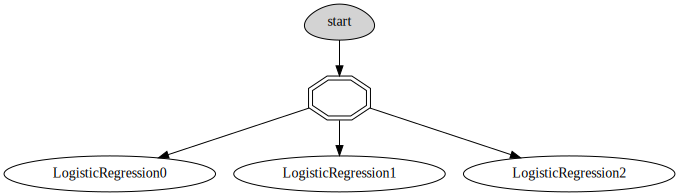

In [8]:
# Importing serving function from marketplace:
serving_fn = mlrun.new_function("serving", kind="serving", image="yhaviv/mlrun:dev")
serving_fn.with_code(body=" ")
serving_fn.with_requirements("./requirements.txt")

# Set the real-time pipeline topology
serving_fn.set_topology(
    'router', 
    'mlrun.serving.routers.VotingEnsemble'
)

# Add the trained models:
artifacts = mlrun.get_run_db().list_artifacts(project=project.name)
models = {f"{model['algorithm']}{i}" :f"{model['db_key']}#{model['iter']}" 
          for i, model in enumerate(artifacts) if model["kind"]=="model"}

for name, path in models.items():
    serving_fn.add_model(
        name, 
        class_name="mlrun.frameworks.sklearn.PickleModelServer", 
        model_path=project.get_artifact_uri(path))

serving_fn.spec.graph.plot()

### Building and Deploying the Serving Function

In [9]:
function_address = serving_fn.deploy()

> 2022-01-31 14:58:09,176 [info] Starting remote function deploy
2022-01-31 14:58:10  (info) Deploying function
2022-01-31 14:58:10  (info) Building
2022-01-31 14:58:10  (info) Staging files and preparing base images
2022-01-31 14:58:11  (info) Building processor image
2022-01-31 14:58:12  (info) Build complete
2022-01-31 14:58:23  (info) Function deploy complete
> 2022-01-31 14:58:23,955 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-azureml-yonatan-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['azureml-yonatan-serving-azureml-yonatan.default-tenant.app.yh41.iguazio-cd1.com/']}


## 5. Using the Live Model-Serving Function

In [10]:
print (f'The address for the function is {function_address} \n')

!curl $function_address

The address for the function is http://azureml-yonatan-serving-azureml-yonatan.default-tenant.app.yh41.iguazio-cd1.com/ 

{"name": "VotingEnsemble", "version": "v2", "extensions": []}

In [11]:
# Data for testing:
source_df = mlrun.get_dataitem(DATA_URL).as_df()
test_vector = source_df.sample(5).drop('label', axis=1).values.tolist()
test_vector

[[5.4, 3.4, 1.7, 0.2],
 [6.9, 3.1, 5.4, 2.1],
 [6.3, 3.3, 6.0, 2.5],
 [5.4, 3.0, 4.5, 1.5],
 [5.8, 2.6, 4.0, 1.2]]

After deploying the serving function with the required model we can make prediction:

In [12]:
serving_fn.invoke(f'/v2/models/infer', {"inputs": test_vector})

> 2022-01-31 14:58:24,955 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-azureml-yonatan-serving.default-tenant.svc.cluster.local:8080/v2/models/infer'}


{'id': '0ad4175d-ea5c-4790-b52c-ea6be5cc4b00',
 'model_name': 'VotingEnsemble',
 'outputs': [0, 2, 2, 1, 1],
 'model_version': 'v1'}

## 6. Clean up

For cleaning up AzureML resources see:
https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-models#clean-up-resources